Imports and constants

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
from pathlib import Path
from tqdm import tqdm

import torch
import torch.utils.data as thd
import torch.nn as nn

from sklearn.metrics import fbeta_score, precision_score, recall_score
from scipy.ndimage.filters import gaussian_filter1d

import matplotlib.pyplot as plt
from collections import defaultdict
import os
import gc
from operator import itemgetter
from pympler import tracker

# Ignore SKLearn warnings
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)

BATCH_SIZE = 256
BUFFER = 10  # Buffer size in both dimensions: x and y. Effective patch size is [BUFFER * 2 + 1, BUFFER * 2 + 1, Z_DIM].
SLICES = 65
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 0.3
Z_START = 24
Z_END = 34
Z_STEP = 1
Z_DIM = (Z_END - Z_START) // Z_STEP
TRAIN_ON_FRAGMENTS = [1, 2]
VAL_FRAGMENT = 3
DISABLE_TQDM = True

MAX_TRAIN_STEPS = 50000
MAX_VAL_STEPS = 1000
PRINT_EVERY = 20000000

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


First, let's see if we can fit all one full fragment into memory at once.

In [2]:
def pad_array(array):
    padding = (
        (BUFFER, BUFFER),
        (BUFFER, BUFFER),
    )
    return np.pad(array, padding)

def load_fragment_surface(fragment, split='train'):
    print("Loading fragment %s surface" % fragment)
    surface_path = Path("/kaggle/input/vesuvius-challenge-ink-detection/%s/%s/surface_volume" % (split, fragment))
    return np.array([
        (pad_array(np.array(Image.open(f))) / (2 ** 16)).astype('float16')
        for f in tqdm(sorted(surface_path.rglob("*.tif"))[Z_START:Z_END:Z_STEP], disable=DISABLE_TQDM)
    ])

def load_mask(fragment, split='train'):
    print("Loading fragment %s mask" % fragment)
    mask_path = Path("/kaggle/input/vesuvius-challenge-ink-detection/%s/%s/mask.png" % (split, fragment))
    return pad_array(np.array(Image.open(mask_path)))

def load_inklabels(fragment, split='train'):
    print("Loading fragment %s labels" % fragment)
    inklabels_path = Path("/kaggle/input/vesuvius-challenge-ink-detection/%s/%s/inklabels.png" % (split, fragment))
    return pad_array(np.array(Image.open(inklabels_path)))

In [3]:
class SingleFragmentDataset(thd.Dataset):
    def __init__(self, fragment, is_test=False):
        self.is_test = is_test
        split = 'test' if is_test else 'train'
        self.surface = load_fragment_surface(fragment, split)
        print(self.surface.dtype)
        self.mask = load_mask(fragment, split)
        self.inklabels = load_inklabels(fragment, split) if not is_test else None
        self.pixels = np.stack(np.where(self.mask == 1), axis=1)
    
    def __len__(self):
        return self.pixels.shape[0]
    
    def get_pixel_number(self, y, x):
        return 1 + y * self.surface.shape[2] + x
    
    def __getitem__(self, index):
        y, x = self.pixels[index]
        y_start = y - BUFFER
        y_end = y + BUFFER + 1
        x_start = x - BUFFER
        x_end = x + BUFFER + 1
        patch_surface = np.s_[:, y_start:y_end, x_start:x_end]
        patch_labels = np.s_[y_start:y_end, x_start:x_end]
        surface = self.surface[patch_surface].astype(np.float32)
        labels = self.inklabels[y, x].reshape((1, )).astype(np.float32) if not self.is_test else None
        return (surface, labels) if not self.is_test else (surface, self.get_pixel_number(y, x))

Define the model

In [4]:
convnet = nn.Sequential(
    nn.Conv2d(Z_DIM, 32, kernel_size=3, stride=1, dilation=1, padding='same'),
    nn.Dropout(p=0.2),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.Conv2d(32, 16, kernel_size=3, stride=1, dilation=1, padding='same'),
    nn.Dropout(p=0.2),
    nn.ReLU(),
    nn.BatchNorm2d(16),
    nn.Conv2d(16, 8, kernel_size=3, stride=1, dilation=1, padding='same'),
    nn.Dropout(p=0.2),
    nn.ReLU(),
    nn.BatchNorm2d(8),
    nn.Conv2d(8, 1, kernel_size=3, stride=1, dilation=1, padding='same'),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear((2 * BUFFER + 1) ** 2, 128),
    nn.Dropout(p=0.2),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.Dropout(p=0.2),
    nn.ReLU(),
    nn.Linear(64, 1),
    nn.Sigmoid()
).to(DEVICE)

Train the model

Loading fragment 1 surface
float16
Loading fragment 1 mask
Loading fragment 1 labels
(10, 8201, 6350)
0


/opt/conda/lib/python3.10/site-packages/torch/distributed/distributed_c10d.py:283: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(


[['str', 309992, 50250916], ['dict', 105587, 34571688], ['code', 80899, 14403585], ['type', 11080, 10510472], ['list', 64718, 6494376], ['tuple', 93826, 5977656], ['set', 3798, 2382224], ['collections.OrderedDict', 3005, 1694936], ['weakref.ReferenceType', 18799, 1353528], ['builtin_function_or_method', 16292, 1173024]]
Loading fragment 2 surface


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3176: DecompressionBombWarning: Image size (140973980 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


float16
Loading fragment 2 mask
Loading fragment 2 labels
(10, 14850, 9526)
20


/opt/conda/lib/python3.10/site-packages/torch/distributed/distributed_c10d.py:283: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(


[['str', 313212, 50542076], ['dict', 105885, 34663040], ['code', 80901, 14446737], ['type', 11081, 10512744], ['list', 64846, 6535704], ['tuple', 93888, 5981176], ['set', 3832, 2394176], ['collections.OrderedDict', 3005, 1694936], ['weakref.ReferenceType', 19075, 1373400], ['builtin_function_or_method', 16570, 1193040]]
CPU times: user 2min 14s, sys: 19.8 s, total: 2min 33s
Wall time: 3min 31s


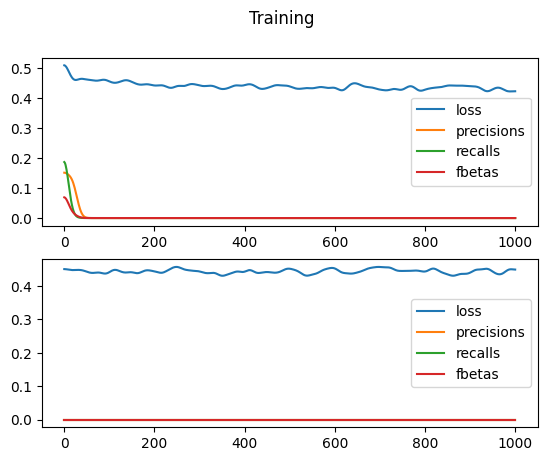

In [5]:
%%time

criterion = nn.BCELoss()

fig, axs = plt.subplots(2)
fig.suptitle('Training')

def train(fragment_number, pltaxs):
    train_dataset = SingleFragmentDataset(fragment_number)
    print(train_dataset.surface.shape)
    train_loader = thd.DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
    
    print(gc.collect())
    mem = tracker.SummaryTracker()
    print(sorted(mem.create_summary(), reverse=True, key=itemgetter(2))[:10])
    
    losses = []
    fbetas = []
    precisions = []
    recalls = []

    convnet.train()
    optimizer = torch.optim.SGD(convnet.parameters(), lr=LEARNING_RATE)
    for i, (xs, ys) in enumerate(pbar := tqdm(train_loader, disable=DISABLE_TQDM)):
        if i > MAX_TRAIN_STEPS:
            break
        optimizer.zero_grad()
        outputs = convnet(xs.to(DEVICE))
        loss = criterion(outputs, ys.to(DEVICE))
        pred_ink = outputs.detach().gt(0.4).cpu().int()
        fbeta = fbeta_score(ys.view(-1).numpy(), pred_ink.view(-1).numpy(), beta=0.5)
        precision = precision_score(ys.view(-1).numpy(), pred_ink.view(-1).numpy())
        recall = recall_score(ys.view(-1).numpy(), pred_ink.view(-1).numpy())
        pbar.set_postfix({"loss": loss, "prec": precision, "rec": recall, "fbeta": fbeta})
        loss.backward()
        optimizer.step()

        fbetas.append(fbeta)
        losses.append(loss.detach().cpu().float())
        precisions.append(precision)
        recalls.append(recall)
    
    del train_loader
    del train_dataset
    gc.collect()
    
    pltaxs.plot(gaussian_filter1d(losses, sigma=25), label='loss')
    pltaxs.plot(gaussian_filter1d(precisions, sigma=25), label='precisions')
    pltaxs.plot(gaussian_filter1d(recalls, sigma=25), label='recalls')
    pltaxs.plot(gaussian_filter1d(fbetas, sigma=25), label='fbetas')
    pltaxs.legend()

for i, fragment_number in enumerate(TRAIN_ON_FRAGMENTS):
    train(fragment_number, axs[i])

Validate the model

Loading fragment 3 surface
float16
Loading fragment 3 mask
Loading fragment 3 labels
Evaluating for threshold 0.100000
Evaluating for threshold 0.200000
Evaluating for threshold 0.300000
Evaluating for threshold 0.400000
Evaluating for threshold 0.500000
Evaluating for threshold 0.600000
Evaluating for threshold 0.700000
Evaluating for threshold 0.800000
Evaluating for threshold 0.900000
Best threshold: 0.2


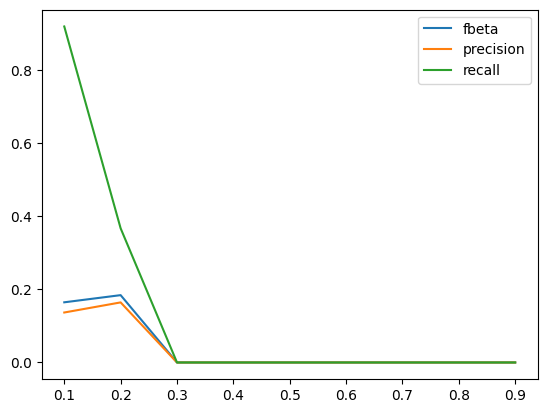

In [6]:
convnet.eval()
val_dataset = SingleFragmentDataset(VAL_FRAGMENT)
val_loader = thd.DataLoader(val_dataset, BATCH_SIZE, shuffle=True)

def evaluate(convnet, val_loader, threshold):
    print("Evaluating for threshold %f" % threshold)
    losses = []
    accs = []
    fbetas = []
    precisions = []
    recalls = []

    for i, (xs, ys) in enumerate(pbar := tqdm(val_loader, disable=DISABLE_TQDM)):
        if i > MAX_VAL_STEPS:
            break
        outputs = convnet(xs.to(DEVICE))
        loss = criterion(outputs, ys.to(DEVICE))
        pred_ink = outputs.detach().gt(threshold).cpu().int()
        accuracy = (pred_ink == ys).sum().float().div(ys.size(0))
        fbeta = fbeta_score(ys.view(-1).numpy(), pred_ink.view(-1).numpy(), beta=0.5)
        precision = precision_score(ys.view(-1).numpy(), pred_ink.view(-1).numpy())
        recall = recall_score(ys.view(-1).numpy(), pred_ink.view(-1).numpy())
        pbar.set_postfix({"loss": loss, "acc": accuracy, "fbeta": fbeta})

        fbetas.append(fbeta)
        losses.append(loss.detach().cpu().float())
        accs.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
    
    return np.mean(losses), np.mean(accs), np.mean(fbetas), np.mean(precisions), np.mean(recalls)


def evaluate_for_thresholds():
    thresholds = [0.1, 0.125, 0.15, 0.175, 0.2, 0.25, 0.325, 0.4]
    
    best_fbeta = 0.
    best_threshold = 0
    
    fbetas = []
    precisions = []
    recalls = []

    for threshold in thresholds:
        _, _, fbeta, precision, recall = evaluate(convnet, val_loader, threshold)
        if fbeta > best_fbeta:
            best_fbeta = fbeta
            best_threshold = threshold
        fbetas.append(fbeta)
        precisions.append(precision)
        recalls.append(recall)
    
    plt.plot(thresholds, fbetas, label="fbeta")
    plt.plot(thresholds, precisions, label="precision")
    plt.plot(thresholds, recalls, label="recall")
    plt.legend()
    
    return best_threshold

best_threshold = evaluate_for_thresholds()
print("Best threshold:", best_threshold)

Generate test predictions

In [7]:
del val_loader
del val_dataset
gc.collect()

submission = defaultdict(list)

for fragment in ['a', 'b']:
    pixels_with_ink = []
    print(f"Generating predictions for fragment {fragment}")
    test_dataset = SingleFragmentDataset(fragment, is_test=True)
    test_loader = thd.DataLoader(test_dataset, BATCH_SIZE, shuffle=True)
    for (xs, ys) in (pbar := tqdm(test_loader, disable=DISABLE_TQDM)):
        outputs = convnet(xs.to(DEVICE))
        pred_ink = outputs.detach().gt(best_threshold).flatten().cpu().int()
        pred_ink = pred_ink[:len(ys)]
        pixels_with_ink += ys[pred_ink == 1].int().tolist()
    pixels_with_ink.sort()
    
    submission["Id"].append(fragment)
    submission["Predicted"].append(' '.join(list(map(lambda p: "%s 1" % p, pixels_with_ink))))
    
pd.DataFrame.from_dict(submission).to_csv("/kaggle/working/submission.csv", index=False)

Generating predictions for fragment a
Loading fragment a surface
float16
Loading fragment a mask


KeyboardInterrupt: 

In [ ]:
pd.DataFrame.from_dict(submission)